![image-2.png](attachment:image-2.png)

# Machine Learning with PySpark
By VISION Team

In [ ]:
#!pip install pyspark

In [ ]:
!pip install -q findspark

In [1]:
#lets import the usual suspects

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#other imports we will be needing in this notebook

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import col, isnan, when, count

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# for ml Classification 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SQLContext


warnings.filterwarnings('ignore')

### Connect to the Spark server

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

### Obtain the Data

In [3]:
#Loading in the data, printing the schema, and showing the top 20 rows
Data = spark.read.csv(r'diabetes_012_health_indicators_BRFSS2015.csv', sep=',', header = True, inferSchema = True)
Data.printSchema()

root
 |-- Diabetes_012: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [4]:
Data.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

### Data Preprocessing

In [5]:
print("There are", Data.count(), "rows", len(Data.columns), "Columns")

There are 253680 rows 22 Columns


In [6]:
# This is giving us the count of the missing values in the columns 

Data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Data.columns]).show()
#Data.select([count(when(isnan(c), c)).alias(c) for c in Data.columns]).show()



+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|           0|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|
+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-

In [7]:
# describe() function to extract the statistics of the numerical columns in the table
numeric= [t[0] for t in Data.dtypes if t[1] =='double']
Data.select(numeric).describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
Diabetes_012,253680,0.29692131819615264,0.6981597284091021,0.0,2.0
HighBP,253680,0.4290011037527594,0.4949344626899021,0.0,1.0
HighChol,253680,0.4241209397666351,0.49420980465688547,0.0,1.0
CholCheck,253680,0.9626695048880479,0.1895707543627256,0.0,1.0
BMI,253680,28.382363607694735,6.608694201406024,12.0,98.0
Smoker,253680,0.44316855881425415,0.4967606667785641,0.0,1.0
Stroke,253680,0.04057079785556607,0.19729409940016224,0.0,1.0
HeartDiseaseorAttack,253680,0.09418558814254178,0.2920873147507561,0.0,1.0
PhysActivity,253680,0.7565436770734784,0.4291690433970457,0.0,1.0


## **Exploratory Data Analysis (EDA)**

> PySpark dataframes do not support visualizations like pandas does with its plot() method. So, here we will convert our pyspark dataframe to panda, using the following code:

In [8]:
pandasDF = Data.toPandas()
pandasDF.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


### **1st Plot**

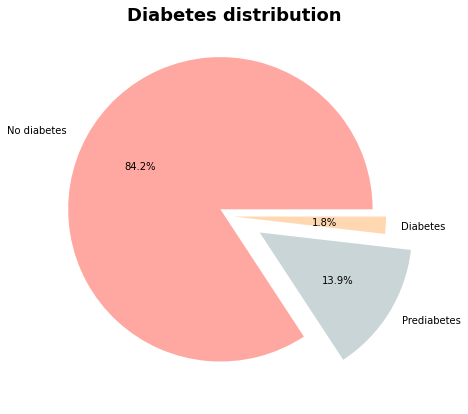

In [9]:
#define color 
c= ['#ffa8a1ff','#cad5d7ff','#ffd8b1ff']

#Set fig size
fig = plt.figure(figsize =(10, 7))

# set the labels of figure 
lable=["No diabetes  ","Prediabetes","Diabetes"]

# Add title
plt.title("Diabetes distribution",fontsize=18,weight = 'bold')


data = pandasDF['Diabetes_012'].value_counts().nlargest(4)
colors = sns.color_palette(c)
plt.pie(data.values, labels=lable, colors=colors, autopct='%1.1f%%',explode = [.1,.2,0])
plt.show()

According to this plot there is class imbalance in this dataset. 

### **2nd plot**

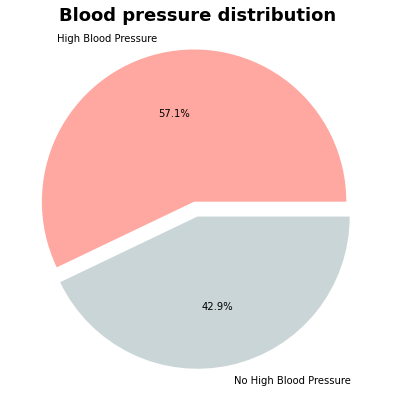

In [10]:

#Set fig size
fig = plt.figure(figsize =(10, 7))

# set the labels of figure 
lable=["High Blood Pressure","No High Blood Pressure "]

# Add title
plt.title("Blood pressure distribution",fontsize=18,weight = 'bold')

data = pandasDF['HighBP'].value_counts().nlargest(4)
colors = sns.color_palette(c)

plt.pie(data.values, labels=lable, colors=colors, autopct='%1.1f%%',explode = [.1,0])
plt.show()

### **3rd plot**

In [11]:
#make copy of dataset 
diabetes_Temp=pandasDF.copy()

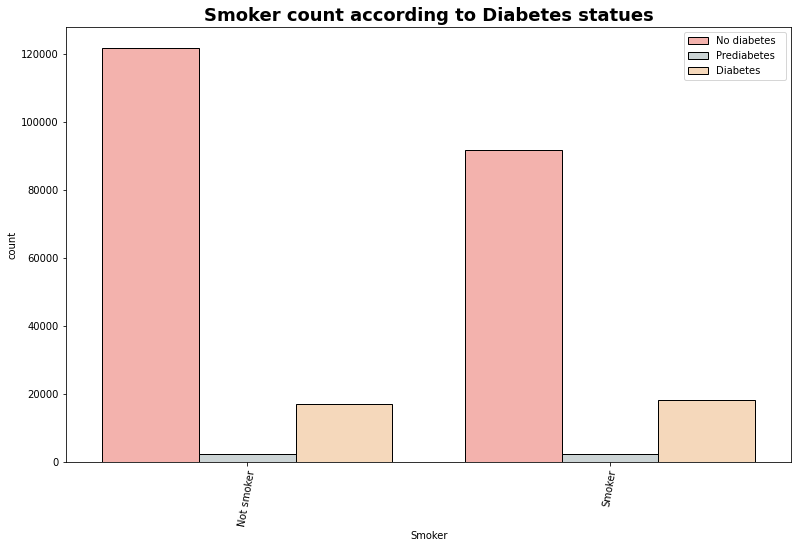

In [12]:
# Smoker count according to Diabetes statues

#Change label of smoker column to make it easy to read and understand labels
diabetes_Temp['Smoker'] = diabetes_Temp['Smoker'].replace({1.0:'Smoker', 0.0:'Not smoker'})


# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

#plotting bar-plot
ax=sns.countplot(x='Smoker', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['Smoker'].value_counts().index,
                edgecolor="black")
#Rotate x-labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

# Add title
plt.title('Smoker count according to Diabetes statues',fontsize=18,weight = 'bold')

#Change leganed labels
plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])

# show plot
plt.show()

### **4th plot**

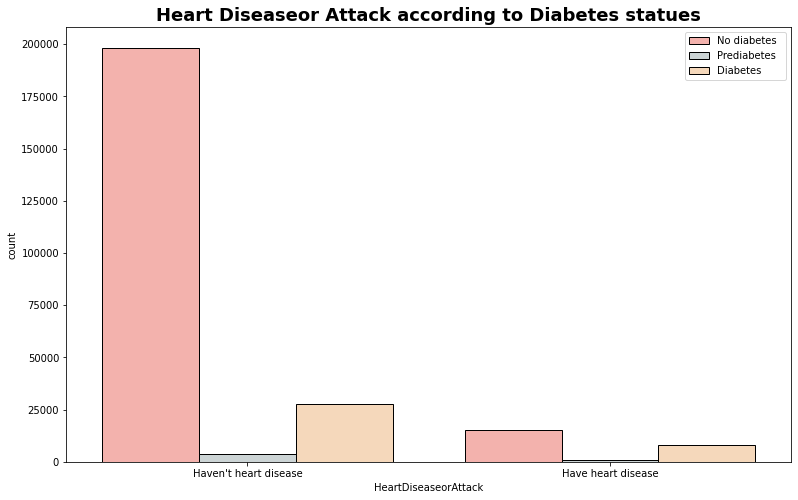

In [13]:
# Heart Diseaseor Attack count according to Diabetes statues

#Change label of HeartDiseaseorAttack column to make it easy to read and understand labels
diabetes_Temp['HeartDiseaseorAttack'] = diabetes_Temp['HeartDiseaseorAttack'].replace({1.0:"Have heart disease", 0.0:"Haven't heart disease"})

# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

#plotting bar-plot
ax=sns.countplot(x='HeartDiseaseorAttack', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['HeartDiseaseorAttack'].value_counts().index,
                edgecolor="black")
#Rotate x-labels

# Add title
plt.title('Heart Diseaseor Attack according to Diabetes statues',fontsize=18,weight = 'bold')

#Change leganed labels
plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])

# show plot
plt.show()

### **5th plot**

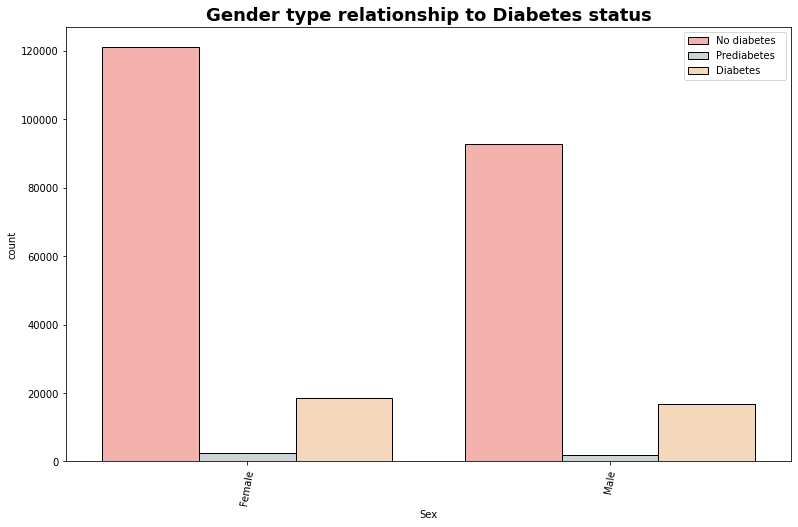

In [14]:
# Sex type relationship to Diabetes status

#Change label of Sex column to make it easy to read and understand labels
diabetes_Temp['Sex'] = diabetes_Temp['Sex'].replace({1.0:"Male", 0.0:"Female"})


# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

gender=["Male","Female"]

#plotting bar-plot
ax=sns.countplot(x='Sex', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['Sex'].value_counts().index,
                edgecolor="black")


#Rotate x-labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

# Add title
plt.title('Gender type relationship to Diabetes status',fontsize=18,weight = 'bold')

#Change leganed labels
plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])

# show plot
plt.show()

### **6th plot**

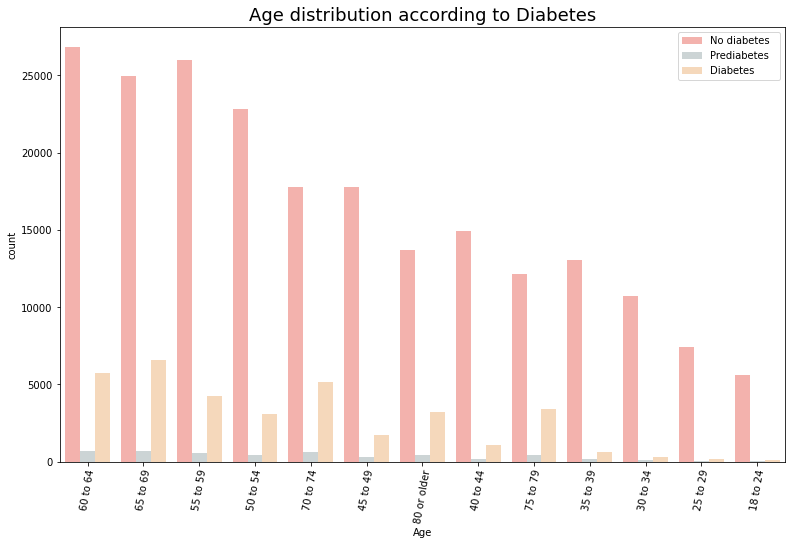

In [15]:

#Change label of columns to make it easy to read and understand labels
diabetes_Temp['Age'] = diabetes_Temp['Age'].replace({1.0:'18 to 24', 2.0:'25 to 29',3.0:'30 to 34',4.0:'35 to 39',5.0:'40 to 44',6.0:'45 to 49',7.0:'50 to 54',8.0:'55 to 59',9.0:'60 to 64',10.0:'65 to 69',11.0:'70 to 74',12.0:'75 to 79',13.0:'80 or older'})

# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

# Add title
plt.title("Age distribution according to Diabetes",fontsize=18)

#plotting count-plot
ax=sns.countplot(x='Age', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['Age'].value_counts().index,)

#Rotate x-labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])


plt.show()

### **7th Plot**

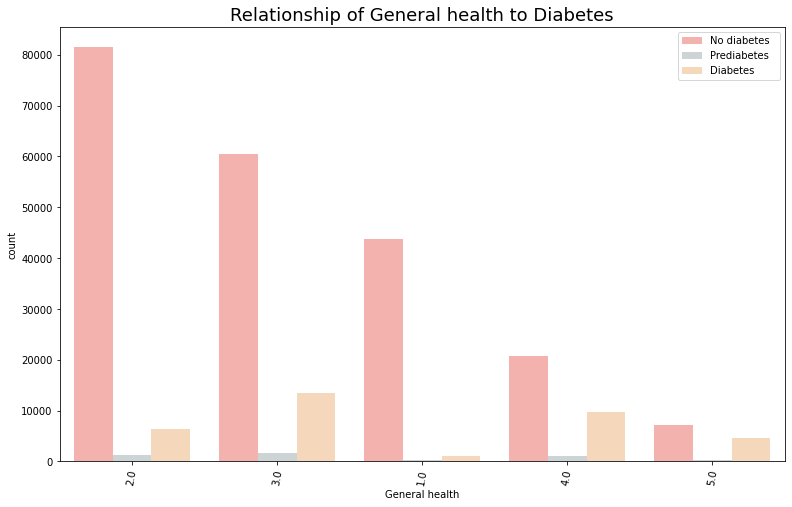

In [16]:

#Relationship of General health to Diabetes

# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

# Add title
plt.title("Relationship of General health to Diabetes",fontsize=18)

#plotting count-plot
ax=sns.countplot(x='GenHlth', data=pandasDF, hue= 'Diabetes_012', palette=c, order = pandasDF['GenHlth'].value_counts().index,)

#Rotate x-labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])

plt.xlabel('General health') #x axis label


plt.show()

### **8th plot**

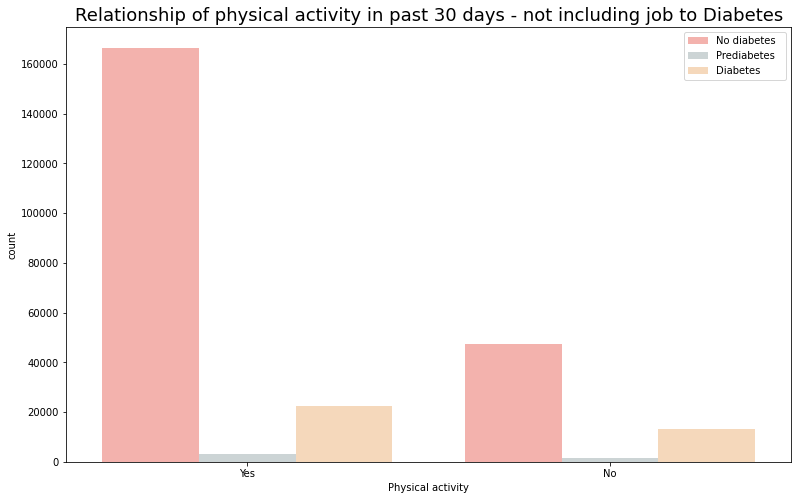

In [17]:

#Relationship of physical activity in past 30 days - not including job to Diabetes

#Change label of columns to make it easy to read and understand labels
diabetes_Temp['PhysActivity'] = diabetes_Temp['PhysActivity'].replace({1.0:'Yes', 0.0:'No'})

# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

# Add title
plt.title("Relationship of physical activity in past 30 days - not including job to Diabetes",fontsize=18)

#plotting count-plot
ax=sns.countplot(x='PhysActivity', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['PhysActivity'].value_counts().index,)

plt.legend(labels=["No diabetes  ","Prediabetes","Diabetes"])

plt.xlabel('Physical activity') #x axis label


plt.show()

### **9th Plot**

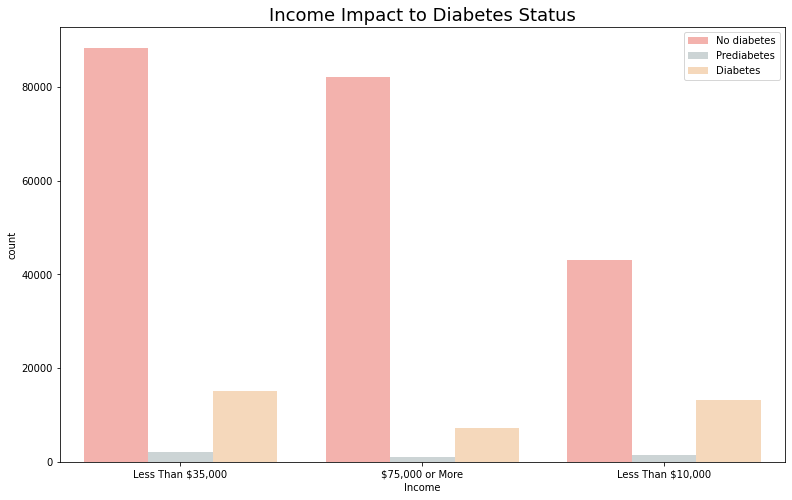

In [18]:
#Change label of columns to make it easy to read and understand labels
diabetes_Temp['Income'] = diabetes_Temp['Income'].replace({1.0:'Less Than $10,000', 2.0:'Less Than $10,000',3.0:'Less Than $10,000',4.0:'Less Than $10,000',5.0:'Less Than $35,000',6.0:'Less Than $35,000',7.0:'Less Than $35,000',8.0:'$75,000 or More'})

# Creating plot

#Set fig size
fig, ax = plt.subplots(figsize=(13,8))

# Add title
plt.title("Income Impact to Diabetes Status",fontsize=18)

#plotting count-plot
ax=sns.countplot(x='Income', data=diabetes_Temp, hue= 'Diabetes_012', palette=c, order = diabetes_Temp['Income'].value_counts().index,)

#Rotate x-labels

plt.legend(labels=["No diabetes","Prediabetes","Diabetes"])


plt.show()

### The Target is 'Diabetes_012' - Replace the class Prediabetes to be Diabetes

In [19]:
Data.groupBy('Diabetes_012').count().show()

+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|213703|
|         1.0|  4631|
|         2.0| 35346|
+------------+------+



In [22]:
from pyspark.sql.functions import *
Data = Data.replace(2.0, 1.0, subset=['Diabetes_012'])

In [23]:
Data.groupBy('Diabetes_012').count().show()

+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|213703|
|         1.0| 39977|
+------------+------+



### Combining Feature Columns

Inputs to Scikit-learn models have the data split into X-arrays/dataframes (features) and Y-arrays/dataframes (predictors). PySpark expects both the features and the predictor to be in a single dataframe. However, all the features have to be combined into a single column containing a list of the feature values. To accomplish this, we use [`VectorAssembler`](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

Note that VectorAssembler uses transform. This is just like the second step of Scikit-learn's feature transformers for normalization, etc.

In [24]:
cols = Data.columns
cols.remove('Diabetes_012') #remove price -> we need this to be our label

assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(Data)

### Set columns and Split

Before modelling, the data are split into train and test data sets. We will make the train set bigger at this point as will incorporate cross validation later on.

In [25]:
# We have created a new dataframe only consisting of the features column and the label column (actually price column but renamed)
df_data = data.select(F.col('features'), F.col('Diabetes_012').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

In [26]:
print("Training Dataset count: ", str(df_train.count()))
print("Test Dataset count: ", str(df_test.count()))
     

Training Dataset count:  202867
Test Dataset count:  50813


### Classification Machine Learning Models

### Initialize Evaluator

As we are dealing with categorical values, we will be using classifier to be trained on the data and then be used in prediction. Accordingly, we will have to use BinaryclassClassificationEvaluator to evaluate all the classifier we will be using.

In [27]:
evaluator = BinaryClassificationEvaluator() # Can specify what metrics we want to use. Default metric is AreaUnderRoc 

### Area Under An ROC Curve 

is a measure of the usefulness of a test in general, where a greater area means a more useful test, the areas under ROC curves are used to compare the usefulness of tests.
The term ROC stands for Receiver Operating Characteristic. it is the default metric for BinaryClassificationEvaluator

### BinaryClassificationEvaluator(*[, …])
Evaluator for binary classification, which expects input columns rawPrediction, label and an optional weight column. The rawPrediction column can be of type double (binary 0/1 prediction, or probability of label 1) or of type vector (length-2 vector of raw predictions, scores, or label probabilities).

### 1st Model: LogisticRegression

In [28]:
lr= LogisticRegression(featuresCol='features', labelCol='label')
lrmodel= lr.fit(df_train)

In [29]:
lrmodel.summary.accuracy

0.8481123100356391

In [30]:
prediction= lrmodel.transform(df_test)
prediction.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1.0,"(1.0, 1.0, 1.0, 30.0, 1.0, 1.0, 0.0, 1.0, 0.0,...","[0.3846421997668079, -0.3846421997668079]",0.0,"[0.5949922553598016, 0.4050077446401984]"
1,0.0,"(1.0, 1.0, 1.0, 23.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[2.2320456247270455, -2.2320456247270455]",0.0,"[0.9030905357209086, 0.09690946427909142]"
2,0.0,"(1.0, 1.0, 1.0, 23.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0.8419161467973879, -0.8419161467973879]",0.0,"[0.698868625129687, 0.30113137487031305]"
3,1.0,"(1.0, 1.0, 1.0, 28.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[-0.23067376152093466, 0.23067376152093466]",1.0,"[0.4425859195690519, 0.5574140804309481]"
4,1.0,"(1.0, 1.0, 1.0, 32.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0.9579387875135605, -0.9579387875135605]",0.0,"[0.7227089263072565, 0.27729107369274353]"


In [31]:
print('Test Area Under ROC', evaluator.evaluate(prediction))

Test Area Under ROC 0.8136159890385588


In [32]:
ParamGrid = (ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.5, 2]).addGrid(lr.elasticNetParam, [0.0, 0.5,1.0]).addGrid(lr.maxIter,[1,5,10]).build())


In [33]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(df_train)

In [34]:
#Best Model Performance
Predictions= cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))    

Best Model Test Area Under ROC 0.8137380516181675


In [35]:
#Best Model Parameters
best_model= cvModel.bestModel

print('Best Param (regParam): ',best_model._java_obj.getRegParam())
print('Best Param (MaxIter): ', best_model._java_obj.getMaxIter())
print('Best Param (eleasticNetParam): ', best_model._java_obj.getElasticNetParam()) 

Best Param (regParam):  0.01
Best Param (MaxIter):  10
Best Param (eleasticNetParam):  0.0


### 2nd Model: DecisionTreeClassifier

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
dc = DecisionTreeClassifier()    

In [37]:
ParamGrid = (ParamGridBuilder().addGrid(dc.maxDepth, [2,3,5,10,15, 20]).addGrid(dc.maxBins, [5,10,20,30,40,50]).build())
cv = CrossValidator(estimator=dc, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
dc_cvModel= cv.fit(df_train)

#Best Model Performance
Predictions= dc_cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))
     

Best Model Test Area Under ROC 0.6392430400647642


In [38]:
#Best Model Parameters
best_model= dc_cvModel.bestModel

print('Best Param (maxDepth): ',best_model._java_obj.getMaxDepth())
print('Best Param (maxBins): ', best_model._java_obj.getMaxBins())

Best Param (maxDepth):  10
Best Param (maxBins):  10


### 3rd Model: RandomForestClassifier

In [55]:
from pyspark.ml.classification import RandomForestClassifier
rfc= RandomForestClassifier()

In [57]:
ParamGrid = (ParamGridBuilder().addGrid(rfc.numTrees, [2,3,5,10,15,20]).addGrid(rfc.maxDepth, [5,10,15,20]).addGrid(rfc.maxBins, [10,20,30,40,50]).build())
cv = CrossValidator(estimator=rfc, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
rfc_cvModel= cv.fit(df_train)

#Best Model Performance
Predictions= rfc_cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
#Best Model Parameters
best_model= rfc_cvModel.bestModel

print('Best Param (maxDepth): ',best_model._java_obj.getMaxDepth())
print('Best Param (maxBins): ', best_model._java_obj.getMaxBins())

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\Mylab1\anaconda3\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\Mylab1\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Mylab1\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "C:\Users\Mylab1\anaconda3\lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


### 4th Model: Gradient-boosted tree classifier

In [39]:
from pyspark.ml.classification import GBTClassifier
gbt= GBTClassifier()

In [40]:
ParamGrid = (ParamGridBuilder().addGrid(gbt.maxIter, [5,10,15,20,25]).build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
gbt_cvModel= cv.fit(df_train)

#Best Model Performance
Predictions= gbt_cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

Best Model Test Area Under ROC 0.8187919495109452


In [41]:
#Best Model Parameters
best_model= gbt_cvModel.bestModel

print('Best Param (MaxIter): ', best_model._java_obj.getMaxIter())

Best Param (MaxIter):  25


### 5th Model: Linear Support Vector Machine

In [42]:
from pyspark.ml.classification import LinearSVC
l_SVC =LinearSVC()

In [43]:
ParamGrid = (ParamGridBuilder().addGrid(l_SVC.maxIter, [2,3,5,10,15, 20]).addGrid(l_SVC.regParam, [0.1, 0.2,0.5]).build())
cv = CrossValidator(estimator=l_SVC, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
l_SVC_cvModel= cv.fit(df_train)

#Best Model Performance
Predictions= l_SVC_cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))


Best Model Test Area Under ROC 0.8120327161636189


In [44]:
#Best Model Parameters
best_model= l_SVC_cvModel.bestModel
print('Best Param (maxIter): ',best_model._java_obj.getMaxIter())
print('Best Param (regParam): ', best_model._java_obj.getRegParam())


Best Param (maxIter):  5
Best Param (regParam):  0.5


### 6th Model: Naive Bayes

In [48]:
from pyspark.ml.classification import NaiveBayes
nb= NaiveBayes()

In [49]:
nb_Model= nb.fit(df_train)

#Best Model Performance
Predictions= nb_Model.transform(df_test)
print("Test Area Under ROC", evaluator.evaluate(Predictions))

Test Area Under ROC 0.3039788231876163


### 7th Model: Factorization machines classifier

In [50]:
from pyspark.ml.classification import FMClassifier
fmc= FMClassifier()

In [51]:
ParamGrid = (ParamGridBuilder().addGrid(fmc.stepSize, [0.001,0.01,0.1]).build())
cv = CrossValidator(estimator=fmc, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
fmc_cvModel= cv.fit(df_train)

#Best Model Performance
Predictions= fmc_cvModel.transform(df_test)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

Best Model Test Area Under ROC 0.812028536904747


### The best classification model is LogisticRegression